![](https://www.nuplan.org/static/media/nuPlan_final.3fde7586.png)

### Contents

1. [Introduction to nuPlan](#introduction)
2. [Training an ML planner](#training)
3. [Simulating a planner](#simulation)
4. [Visualizing metrics and scenarios](#dashboard)

In [1]:
from tutorials.utils.tutorial_utils import setup_notebook

setup_notebook()

# Introduction to nuPlan <a name="introduction"></a>


Welcome to nuPlan! This notebook will explore the nuPlan simulation framework, training platform as well as the nuBoard metrics/scenarios visualization dashboard.

## What is nuPlan

nuPlan is the world’s first closed-loop ML-based planning benchmark for autonomous driving.

It provides a high quality dataset with 1500h of human driving data from 4 cities across the US and Asia with widely varying traffic patterns (Boston, Pittsburgh, Las Vegas and Singapore). In addition, it provides a closed-loop simulation framework with reactive agents, a training platform as well as a large set of both general and scenario-specific planning metrics.

![](https://www.nuscenes.org/static/media/framework_steps.2d4642df.png)

## Training & simulation framework

The nuPlan training and simulation framework aims to:
* create a simulation pipeline to evaluate a planner on large dataset with various scenarios
* score planner performance with common and scenario-dependent metrics
* compare planners based on measured metrics and provide intuitive visualizations
* train planners with the provided framework to allow quick implementation and iteration
* support closed-loop simulation and training

<br />

![](https://www.nuplan.org/static/media/planning_framework.ca3c2969.png)

## Scenarios in nuPlan

nuPlan aims to capture challenging yet representative scenarios from real-world encounters. This enables the benchmarking of planning systems both in expert imitation (open-loop) and reactive planning (closed-loop) settings.

These scenarios includes:
* highly interactive scenes with traffic participants (e.g. tailgating, high-velocity overtakes, double parked cars, jaywalking)
* various ego behaviors (e.g. vehicle following, yielding, lane merging) and dynamics (e.g. mixed speed profiles, abrupt braking, speed bumps, high jerk maneuvers)
* scene layouts of varied complexity (e.g. pudos, traffic/stop controlled intersections, unprotected turns) and temporary zones (e.g. construction areas)

The dataset is automatically tagged with scenario labels based on certain primitive attributes.
These scenario tags can then be used to extract representative metrics for the planner's evaluation.

Example mined scenarios in nuPlan:

| | | |
| :-: | :-: | :-: |
| Unprotected cross turn | Dense vehicle interactions | Jaywalker in front |
| ![](https://www.nuscenes.org/static/media/unprotected-cross.51feef7e.webp) | ![](https://www.nuscenes.org/static/media/dense-interactions.16de47ec.webp) | ![](https://www.nuscenes.org/static/media/jaywalker.03083823.webp) |
| Lane change | Ego at pickup/dropoff area | Ego following vehicle |
| ![](https://www.nuscenes.org/static/media/lane-change.54bfca1c.webp) | ![](https://www.nuscenes.org/static/media/pickup-dropoff.4dd1c418.webp) | ![](https://www.nuscenes.org/static/media/following-vehicle.4cacd559.webp) |

## Database

Download a database for training/simulation from [here](https://nuplan.org/nuplan#download).

| Database | Size | Duration | Num Logs | Cities | Num Scenarios | Sensor Data | Description |
| :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- |
| nuplan_v1.1_mini (recommended) | 13GB | 7h | 64 | Las Vegas, Boston, Pittsburgh, Singapore | 67 | N/A | The mini split used for prototyping and testing |
| nuplan_v1.1 | 1.8TB | 1282h | 15910 | Las Vegas, Boston, Pittsburgh, Singapore | 73 | N/A | The full dataset for training and evaluation|

## Setup

To be able to access all resources within this notebook, make sure Jupyter is launched at the root of this repo. The path of the notebook should be `/notebook/<repo_root>`.

In [2]:
# (Optional) Increase notebook width for all embedded cells to display properly
from IPython.display import display, HTML
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# Useful imports
import os
from pathlib import Path
import tempfile

import hydra

# Training an ML planner <a name="training"></a>

## Imitation learning
In the following section we will train an ML planning policy with the aim estimate the ego's future trajectory and control the vehicle.

The policy is learned through imitation learning, a supervised learning approach in which - in the context of autonomous driving - the behavior of an expert human driver is used as a target signal to supervise the model.

## Model features & targets
A planning policy consumes a set of episodic observations and encodes them through a deep neural network to regress a future trajectory.

The observations can be historic or present ego and agent poses as well as static/dynamic map information across different map layers.<br />
These signals can be encoded through various representations, such as raster or vector format for the map signal, each with their pros and cons for each model flavor.

Using these input features the model predicts a discretized future trajectory across a fixed time horizon.<br />
The trajectory consists of a set of discrete future states (position, heading and velocity) sampled at fixed intervals which express the likelihood of the vehicle being at that state in the future.<br />
For example, a predicted trajectory may consist of 10 future poses sampled at intervals of 0.5s across a 5s horizon.

## Learning objectives
The policy is trained to maximize a set of aggregated objectives such as imitation, collision avoidance, traffic rule violation etc.<br />
Imitation is the core training objective which indicates how close the predicted trajectory is to the expert ground truth and penalizes model predictions that deviate in space and time from the demonstration.

## Training parameters

The following parameter categories define the training protocol which includes the model, metrics, objectives etc.

A working example composition of these parameters can be found in the next section.

---

### ML models

Change the training model with `model=X` where `X` is a config yaml defined in the table below. 

| Model | Description | Config |
| --- | --- | --- |
| Raster model (CNN) | Raster-based model that uses a CNN backbone to encode ego, agent and map information as raster layers<br />Any (pretrained) backbone from the TIMM library can be used (e.g. ResNet50, EfficientNetB3) | `raster_model` |
| Vector model (LaneGCN) | Vector-based model that uses a series of MLPs to encode ego and agent signals, a lane graph to encode vector-map elements and a fusion network to capture lane & agent intra/inter-interactions through attention layers<br />Implementation of LaneGCN paper ("Learning Lane Graph Representations for Motion Forecasting") | `vector_model` |
| Simple vector model | Toy vector-based model that consumes ego, agent and lane signals through a series of MLPs | `simple_vector_model` |

<br />

### Training objectives

Change the training objectives with `objective=[X, ...]` where `X` is a config yaml defined in the table below. 

| Objective | Description | Config |
| --- | --- | --- |
| Imitation objective | Penalizes the predicted trajectory that deviates from the expert demonstration | `imitation_objective` |

<br />

### Training metrics

Change the training objectives with `training_metric=[X, ...]` where `X` is a config yaml defined in the table below. 

| Metric | Description | Config |
| --- | --- | --- |
| Average displacement error | RMSE translation error across full predicted trajectory | `avg_displacement_error` |
| Average heading error | RMSE heading error across full predicted trajectory | `avg_heading_error` |
| Final displacement error | L2 error of predicted trajectory's final pose translation | `final_displacement_error` |
| Final heading error | L2 error of predicted trajectory's final pose heading | `final_heading_error` |

## Prepare the training config

In [4]:
# Location of path with all training configs
CONFIG_PATH = '../nuplan/planning/script/config/training'
CONFIG_NAME = 'default_training'

# Create a temporary directory to store the cache and experiment artifacts
SAVE_DIR = Path(tempfile.gettempdir()) / 'tutorial_nuplan_framework'  # optionally replace with persistent dir
EXPERIMENT = 'training_raster_experiment'
JOB_NAME = 'train_default_raster'
LOG_DIR = SAVE_DIR / EXPERIMENT / JOB_NAME

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'group={str(SAVE_DIR)}',
    f'cache.cache_path={str(SAVE_DIR)}/cache',
    f'experiment_name={EXPERIMENT}',
    f'job_name={JOB_NAME}',
    'py_func=train',
    '+training=training_raster_model',  # raster model that consumes ego, agents and map raster layers and regresses the ego's trajectory
    'scenario_builder=nuplan_mini',  # use nuplan mini database
    'scenario_filter.limit_total_scenarios=500',  # Choose 500 scenarios to train with
    'lightning.trainer.params.accelerator=ddp_spawn',  # ddp is not allowed in interactive environment, using ddp_spawn instead - this can bottleneck the data pipeline, it is recommended to run training outside the notebook
    'lightning.trainer.params.max_epochs=10',
    'data_loader.params.batch_size=8',
    'data_loader.params.num_workers=8',
])


## Launch tensorboard for visualizing training artifacts

In [5]:
%load_ext tensorboard
%tensorboard --logdir {str(LOG_DIR)}

## Launch training (within the notebook)

In [6]:
from nuplan.planning.script.run_training import main as main_train

# Run the training loop, optionally inspect training artifacts through tensorboard (above cell)
main_train(cfg)

Global seed set to 0


2024-10-21 19:18:52,119 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:20}  Building experiment folders...
2024-10-21 19:18:52,119 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:22}  Experimental folder: /tmp/tutorial_nuplan_framework/training_raster_experiment/train_default_raster/2024.10.21.19.18.52
2024-10-21 19:18:52,119 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-10-21 19:18:52,120 INFO {/home/fyq/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2024-10-21 19:18:52,884	INFO worker.py:1786 -- Started a local Ray instance.


2024-10-21 19:18:53,283 INFO {/home/fyq/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-10-21 19:18:53,283 INFO {/home/fyq/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 28
Number of GPUs per node: 1
Number of threads across all nodes: 28
2024-10-21 19:18:53,283 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-10-21 19:18:53,283 INFO {/home/fyq/nuplan-devkit/nuplan/planning/training/experiments/training.py:41}  Building training engine...
2024-10-21 19:18:53,283 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-10-21 19:18:53,490 INFO {/home/fyq/miniconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:244}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/downloa

Ray objects: 100%|██████████████████████████████| 28/28 [00:02<00:00, 13.45it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
Global seed set to 0
initializing ddp: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All DDP processes registered. Starting ddp with 1 processes
----------------------------------------------------------------------------------------------------



2024-10-21 19:18:56,048 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/scenario_builder.py:171}  Extracted 500 scenarios for training
2024-10-21 19:18:56,048 INFO {/home/fyq/nuplan-devkit/nuplan/planning/training/experiments/training.py:52}  Updating configs based on ddp_spawn strategy is currently not supported. Optimizer and LR Scheduler configs will not be updated.
2024-10-21 19:18:56,050 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/training_callback_builder.py:19}  Building callbacks...
2024-10-21 19:18:56,060 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/training_callback_builder.py:37}  Building callbacks...DONE!
2024-10-21 19:18:56,062 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/run_training.py:62}  Starting training...
2024-10-21 19:18:56,089 INFO {/home/fyq/miniconda3/envs/nuplan/lib/python3.9/site-packages/torch/distributed/distributed_c10d.py:194}  Added key: store_based_barrier_key:1 to store for rank: 0
2024-10-21 19

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | RasterModel | 23.6 M
--------------------------------------
23.6 M    Trainable params
0         Non-trainable params
23.6 M    Total params
94.438    Total estimated model params size (MB)


2024-10-21 19:18:58,303 INFO {/home/fyq/nuplan-devkit/nuplan/planning/training/data_loader/datamodule.py:47}  Number of samples in train set: 328
2024-10-21 19:18:58,303 INFO {/home/fyq/nuplan-devkit/nuplan/planning/training/data_loader/datamodule.py:47}  Number of samples in validation set: 80
2024-10-21 19:18:58,305 INFO {/home/fyq/nuplan-devkit/nuplan/planning/training/modeling/lightning_module_wrapper.py:196}  Using optimizer: torch.optim.Adam
2024-10-21 19:18:58,305 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/lr_scheduler_builder.py:52}  Not using any lr_schedulers.


/home/fyq/miniconda3/envs/nuplan/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:73: UserWarning: num_workers>0, persistent_workers=False, and accelerator=ddp_spawn may result in data loading bottlenecks. Consider setting persistent_workers=True (this is a limitation of Python .spawn() and PyTorch)
  rank_zero_warn(
/home/fyq/miniconda3/envs/nuplan/lib/python3.9/site-packages/pytorch_lightning/callbacks/lr_monitor.py:97: RuntimeWarning: You are using `LearningRateMonitor` callback with models that have no learning rate schedulers. Please see documentation for `configure_optimizers` method.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/fyq/miniconda3/envs/nuplan/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


2024-10-21 19:18:58,713 INFO {/home/fyq/miniconda3/envs/nuplan/lib/python3.9/site-packages/torch/nn/parallel/distributed.py:788}  Reducer buckets have been rebuilt in this iteration.


/home/fyq/miniconda3/envs/nuplan/lib/python3.9/site-packages/pytorch_lightning/trainer/callback_hook.py:100: LightningDeprecationWarning: The signature of `Callback.on_train_epoch_end` has changed in v1.3. `outputs` parameter has been removed. Support for the old signature will be removed in v1.5
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Validating: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


## Launch training (command line - alternative)

A training experiment with the above same parameters can be launched alternatively with:
```
$ python nuplan/planning/script/run_training.py \
    experiment_name=raster_experiment \
    py_func=train \
    +training=training_raster_model \
    scenario_builder=nuplan_mini \
    scenario_filter.limit_total_scenarios=500 \
    lightning.trainer.params.max_epochs=10 \
    data_loader.params.batch_size=8 \
    data_loader.params.num_workers=8
```

# Simulating a planner <a name="simulation"></a>

## Open-loop simulation
Open-loop simulation aims to evaluate the policy's capabilities to imitate the expert driver's behavior.<br />
This is essentially done through log replay as the policy's predictions do not affect the state of the simulation.

As the policy is not in full control of the vehicle, this type of simulation can only provide a high-level performance overview.

## Closed-loop simulation
Conversely, in closed-loop simulation the policy's actions alter the state of the simulation which tries to closely approximate the real-world system.

The simulation's feedback loop enables a more in-depth evaluation of the policy as compounding errors can cause future observations to significantly diverge from the ground truth.<br />
This is important in measuring distribution shifts introduced due to lack of variance in training examples through pure imitation learning.

Closed-loop simulation is further divided into two categories:
* ego closed-loop simulation with agents replayed from log (open-loop, non reactive)
* ego closed-loop simulation with agents controlled by a rule-based or learned policy (closed-loop, reactive)

## Measuring success
Measuring the success of a planning task and comparing various planning policies is a complicated effort that involves defining metrics across different vertical dimensions and scenario categories.<br />
These metrics include indicators such as vehicle dynamics, traffic rule violations, expert imitation, navigation success etc.<br />
Overall, they aim to capture the policy's ability to control the autonomous vehicle safely yet efficiently without compromising the passenger's comfort.

## Simulation parameters

### Planners

Change the planner model with `planner=X` where `X` is a config yaml defined in the table below. 

| Planner | Description | Config |
| --- | --- | --- |
| Simple Planner | Naive planner that only plans a straight path | `simple_planner` |
| ML Planner | Learning-based planner trained using the nuPlan training framework (see previous section) | `ml_planner` |

## Prepare the simulation config

In [9]:
# Location of path with all simulation configs
CONFIG_PATH = '../nuplan/planning/script/config/simulation'
CONFIG_NAME = 'default_simulation'

# Select the planner and simulation challenge
PLANNER = 'simple_planner'  # [simple_planner, ml_planner]
CHALLENGE = 'open_loop_boxes'  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents]
DATASET_PARAMS = [
    'scenario_builder=nuplan_mini',  # use nuplan mini database
    # 'scenario_filter=all_scenarios',  # initially select all scenarios in the database
    'scenario_filter=nuplan_challenge_scenarios',  # initially select all scenarios in the database
    'scenario_filter.scenario_types=[near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]',  # select scenario types
    'scenario_filter.num_scenarios_per_type=10',  # use 10 scenarios per scenario type
]

# Name of the experiment
EXPERIMENT = 'simulation_simple_experiment'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'experiment_name={EXPERIMENT}',
    f'group={SAVE_DIR}',
    f'planner={PLANNER}',
    f'+simulation={CHALLENGE}',
    *DATASET_PARAMS,
])

## Launch simulation (within the notebook)

Global seed set to 0


2024-10-21 19:21:26,076 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2024-10-21 19:21:26,090 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2024-10-21 19:21:26,190 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-10-21 19:21:26,190 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-10-21 19:21:26,190 WARNING {/home/fyq/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:135}  Ray is running, we will shut it down before starting again!
2024-10-21 19:21:26,190 WARNING {/home/fyq/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:135}  Ray is running, we will shut it down before starting again!
2024-10-21 19:21:27,496 INFO {/home/fyq/nuplan-devkit/nuplan/planning/utils/mu

2024-10-21 19:21:28,242	INFO worker.py:1786 -- Started a local Ray instance.


2024-10-21 19:21:28,711 INFO {/home/fyq/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-10-21 19:21:28,711 INFO {/home/fyq/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-10-21 19:21:28,711 INFO {/home/fyq/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 28
Number of GPUs per node: 1
Number of threads across all nodes: 28
2024-10-21 19:21:28,711 INFO {/home/fyq/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 28
Number of GPUs per node: 1
Number of threads across all nodes: 28
2024-10-21 19:21:28,712 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-10-21 19:21:28,712 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DO

Ray objects: 100%|██████████████████████████████| 28/28 [00:01<00:00, 21.41it/s]


2024-10-21 19:21:30,048 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:74}  Building metric engines...
2024-10-21 19:21:30,048 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:74}  Building metric engines...
2024-10-21 19:21:30,059 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:76}  Building metric engines...DONE
2024-10-21 19:21:30,059 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:76}  Building metric engines...DONE
2024-10-21 19:21:30,059 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:80}  Building simulations from 30 scenarios...
2024-10-21 19:21:30,059 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:80}  Building simulations from 30 scenarios...
2024-10-21 19:21:30,129 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:133}  Building

Ray objects: 100%|██████████████████████████████| 30/30 [00:05<00:00,  5.93it/s]


2024-10-21 19:21:35,201 INFO {/home/fyq/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:127}  Number of successful simulations: 30
2024-10-21 19:21:35,201 INFO {/home/fyq/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:127}  Number of successful simulations: 30
2024-10-21 19:21:35,201 INFO {/home/fyq/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:128}  Number of failed simulations: 0
2024-10-21 19:21:35,201 INFO {/home/fyq/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:128}  Number of failed simulations: 0
2024-10-21 19:21:35,202 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-10-21 19:21:35,202 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-10-21 19:21:35,219 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to /tmp/tutorial_nuplan_framework/simulation_simple_experiment/open_loop_boxes/2024.10

Rendering histograms: 100%|███████████████████████| 6/6 [00:00<00:00,  9.67it/s]


2024-10-21 19:21:36,600 INFO {/home/fyq/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:01 [HH:MM:SS]
2024-10-21 19:21:36,600 INFO {/home/fyq/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:01 [HH:MM:SS]
2024-10-21 19:21:36,600 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/run_simulation.py:80}  Finished running simulation!
2024-10-21 19:21:36,600 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/run_simulation.py:80}  Finished running simulation!


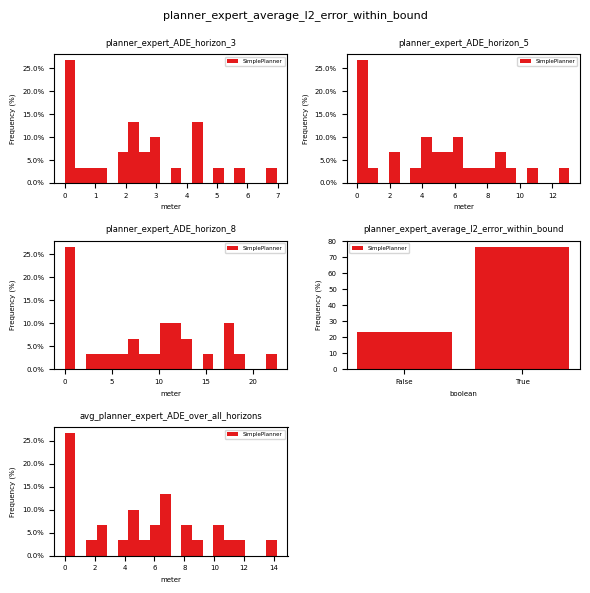

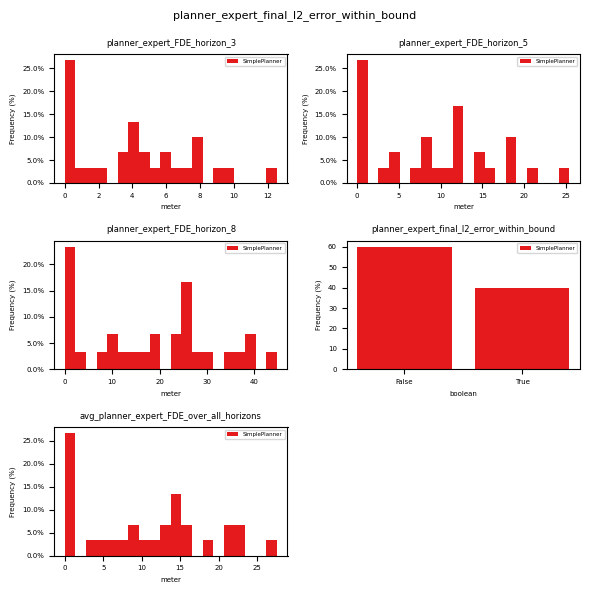

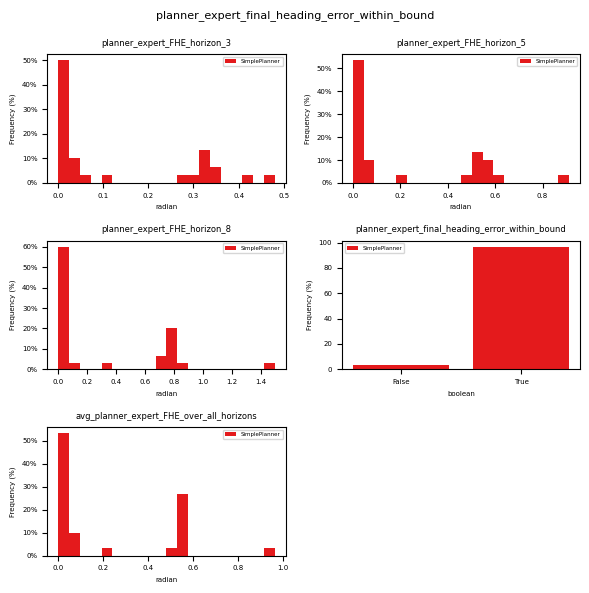

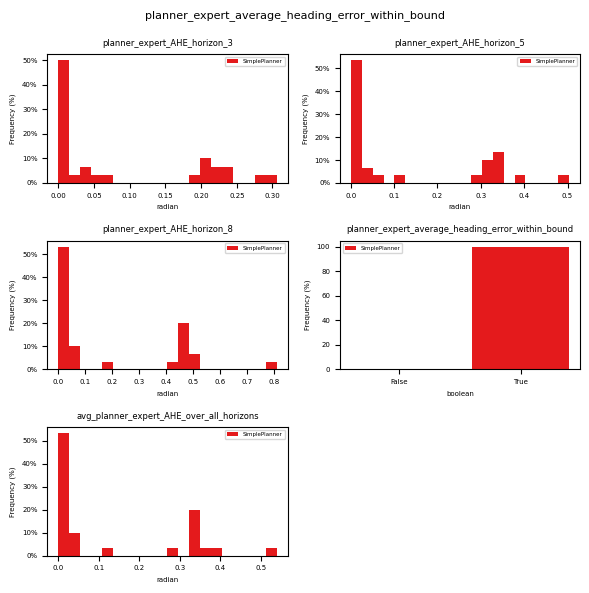

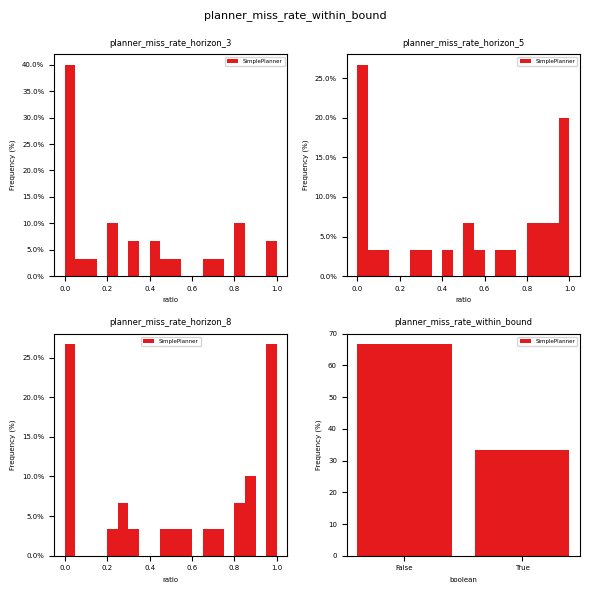

In [10]:
from nuplan.planning.script.run_simulation import main as main_simulation

# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg)

# Simple simulation folder for visualization in nuBoard
simple_simulation_folder = cfg.output_dir

## Launch simulation (command line - alternative)

A simulation experiment can be launched alternatively with:
```
$ python nuplan/planning/script/run_simulation.py \
    +simulation=open_loop_boxes \
    planner=simple_planner \
    scenario_builder=nuplan_mini \
    scenario_filter=all_scenarios \
    scenario_filter.scenario_types="[near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]" \
    scenario_filter.num_scenarios_per_type=10 \
```

## Simulate a trained ML planner for comparison

Using the same simulation settings as before, we can simulate a pretrained ML planner and compare the two.

In this example you can take the model you trained earlier.

In [12]:
DATASET_PARAMS = [
    'scenario_builder=nuplan_mini',  # use nuplan mini database
    # 'scenario_filter=all_scenarios',  # initially select all scenarios in the database
    'scenario_filter=nuplan_challenge_scenarios',  # initially select all scenarios in the database
    'scenario_filter.scenario_types=[near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]',  # select scenario types
    'scenario_filter.num_scenarios_per_type=2',  # use 10 scenarios per scenario type
]

Global seed set to 0


2024-10-21 19:24:13,280 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2024-10-21 19:24:13,280 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2024-10-21 19:24:13,291 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2024-10-21 19:24:13,291 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2024-10-21 19:24:13,380 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-10-21 19:24:13,380 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-10-21 19:24:13,380 WARNING {/home/fyq/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:135}  Ray is runni

2024-10-21 19:24:15,903	INFO worker.py:1786 -- Started a local Ray instance.


2024-10-21 19:24:16,271 INFO {/home/fyq/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-10-21 19:24:16,271 INFO {/home/fyq/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-10-21 19:24:16,272 INFO {/home/fyq/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 28
Number of GPUs per node: 1
Number of threads across all nodes: 28
2024-10-21 19:24:16,272 INFO {/home/fyq/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 28
Number of GPUs per node: 1
Number of threads across all nodes: 28
2024-10-21 19:24:16,272 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-10-21 19:24:16,272 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DO

Ray objects: 100%|██████████████████████████████| 28/28 [00:01<00:00, 17.44it/s]


2024-10-21 19:24:17,908 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:74}  Building metric engines...
2024-10-21 19:24:17,908 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:74}  Building metric engines...
2024-10-21 19:24:17,919 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:76}  Building metric engines...DONE
2024-10-21 19:24:17,919 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:76}  Building metric engines...DONE
2024-10-21 19:24:17,919 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:80}  Building simulations from 6 scenarios...
2024-10-21 19:24:17,919 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:80}  Building simulations from 6 scenarios...
2024-10-21 19:24:17,920 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchMo

Ray objects:   0%|                                        | 0/6 [00:00<?, ?it/s](wrapped_fn pid=81879) /home/fyq/miniconda3/envs/nuplan/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(wrapped_fn pid=81879)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Ray objects: 100%|████████████████████████████████| 6/6 [00:24<00:00,  4.13s/it]


2024-10-21 19:24:45,101 INFO {/home/fyq/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:127}  Number of successful simulations: 6
2024-10-21 19:24:45,101 INFO {/home/fyq/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:127}  Number of successful simulations: 6
2024-10-21 19:24:45,101 INFO {/home/fyq/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:128}  Number of failed simulations: 0
2024-10-21 19:24:45,101 INFO {/home/fyq/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:128}  Number of failed simulations: 0
2024-10-21 19:24:45,101 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-10-21 19:24:45,101 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-10-21 19:24:45,118 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to /tmp/tutorial_nuplan_framework/simulation_raster_experiment/open_loop_boxes/2024.10.2

Rendering histograms: 100%|███████████████████████| 6/6 [00:00<00:00,  9.60it/s]


2024-10-21 19:24:46,487 INFO {/home/fyq/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:01 [HH:MM:SS]
2024-10-21 19:24:46,487 INFO {/home/fyq/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:01 [HH:MM:SS]
2024-10-21 19:24:46,487 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/run_simulation.py:80}  Finished running simulation!
2024-10-21 19:24:46,487 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/run_simulation.py:80}  Finished running simulation!


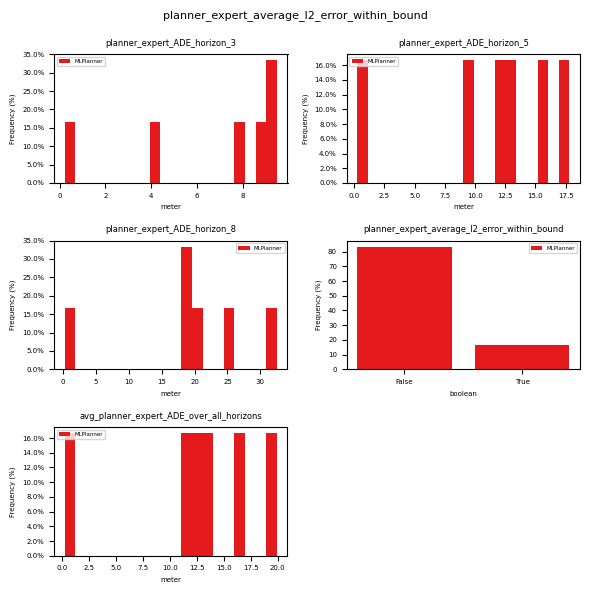

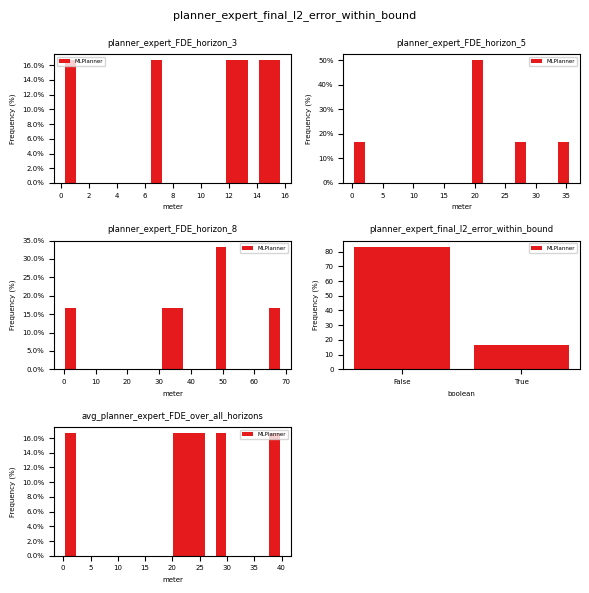

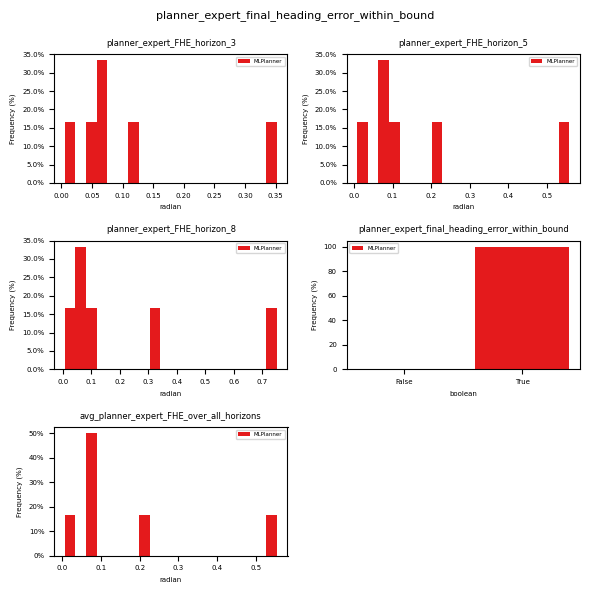

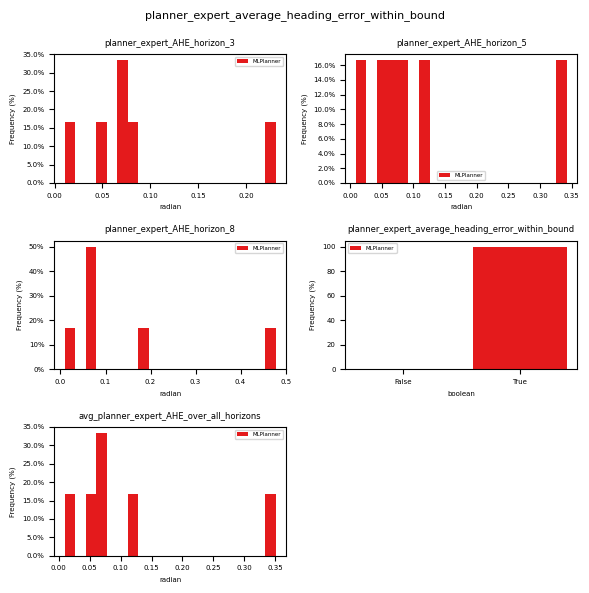

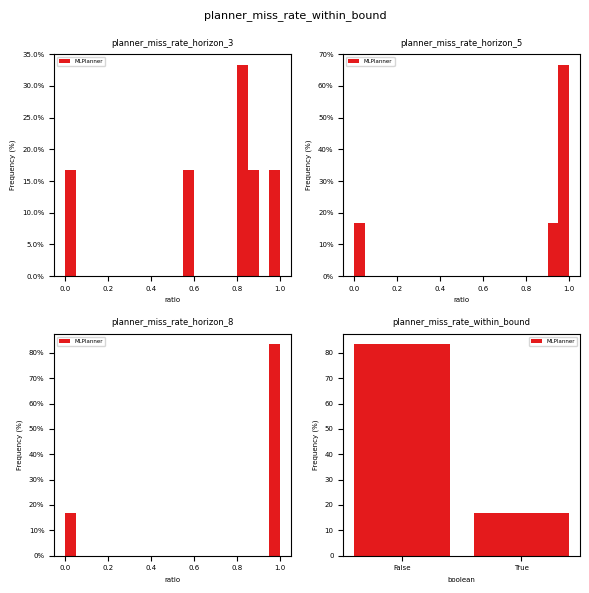

In [13]:
# Location of path with all simulation configs
CONFIG_PATH = '../nuplan/planning/script/config/simulation'
CONFIG_NAME = 'default_simulation'

# Get the checkpoint of the trained model
last_experiment = sorted(os.listdir(LOG_DIR))[-1]
train_experiment_dir = sorted(LOG_DIR.iterdir())[-1]
checkpoint = sorted((train_experiment_dir / 'checkpoints').iterdir())[-1]

MODEL_PATH = str(checkpoint).replace("=", "\=")

# Name of the experiment
EXPERIMENT = 'simulation_raster_experiment'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'experiment_name={EXPERIMENT}',
    f'group={SAVE_DIR}',
    'planner=ml_planner',
    'model=raster_model',
    'planner.ml_planner.model_config=${model}',  # hydra notation to select model config
    f'planner.ml_planner.checkpoint_path={MODEL_PATH}',  # this path can be replaced by the checkpoint of the model trained in the previous section
    f'+simulation={CHALLENGE}',
    *DATASET_PARAMS,
])

# Run the simulation loop2024-10-21 19:24:46,487 INFO {/home/fyq/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:01 [HH:MM:SS]

main_simulation(cfg)

# ML_planner simulation folder for visualization in nuBoard (next section)
ml_planner_simulation_folder = cfg.output_dir

# Visualizing metrics and scenarios <a name="dashboard"></a>

## nuBoard summary

Having trained and simulated planners across various scenarios and driving behaviors, it's time to evaluate them:
* quantitatively, through common and scenario dependent metrics
* qualitatively, through visualization of scenario progression

### nuBoard tabs
To achieve that, nuBoard has 3 core evaluation tabs:
1. Overview - Scalar metrics summary of common and scenario metrics across the following categories:
    * Ego dynamics
    * Traffic violations
    * Expert imitation
    * Planning & navigation
    * Scenario performance
2. Histograms - Histograms over metric statistics for more a granular peek inside each metric focusing on:
    * Metric statistics (e.g. min, max, p90)
3. Scenarios - Low-level scenario visualizations:
    * Time-series progression of a specific metric across a scenario
    * Top-down visualization of the scenario across time for comparing predicted vs. expert trajectories

In addition, there is a main configuration tab for selecting different simulation files for comparing planners/experiments.

<br />

**NOTE**: nuBoard is under heavy developement, overall functionality and aesthetics do not represent the final product!

## Prepare the nuBoard config

In [14]:
# Location of path with all nuBoard configs
CONFIG_PATH = '../nuplan/planning/script/config/nuboard'
CONFIG_NAME = 'default_nuboard'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    'scenario_builder=nuplan_mini',  # set the database (same as simulation) used to fetch data for visualization
    f'simulation_path={[simple_simulation_folder, ml_planner_simulation_folder]}',  # nuboard file path(s), if left empty the user can open the file inside nuBoard
])

## Launch nuBoard (open in new tab - recommended)

In [ ]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

INFO:bokeh.server.server:Starting Bokeh server version 2.4.3 (running on Tornado 6.4.1)
INFO:bokeh.server.tornado:User authentication hooks NOT provided (default user enabled)


2024-10-21 19:26:15,403 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2024-10-21 19:26:15,403 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2024-10-21 19:26:15,411 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2024-10-21 19:26:15,411 INFO {/home/fyq/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2024-10-21 19:26:15,412 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2024-10-21 19:26:15,412 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2024-10-21 19:26:15,412 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nubo

INFO:tornado.access:200 GET / (::1) 155.40ms
INFO:tornado.access:200 GET /resource/spectre.min.css (::1) 0.63ms
INFO:tornado.access:200 GET /resource/spectre-exp.min.css (::1) 0.30ms
INFO:tornado.access:200 GET /resource/spectre-icons.min.css (::1) 0.34ms
INFO:tornado.access:200 GET /resource/style.css (::1) 0.27ms
INFO:tornado.access:200 GET /resource/css/overview.css (::1) 0.50ms
INFO:tornado.access:200 GET /resource/css/cloud.css (::1) 0.69ms
INFO:tornado.access:200 GET /resource/css/scenario.css (::1) 0.89ms
INFO:tornado.access:200 GET /resource/css/histogram.css (::1) 1.06ms
INFO:tornado.access:200 GET /static/js/bokeh.min.js?v=3c61e952b808bb7e346ce828a565a5f23aaf7708d034fa9d0906403813355d45bb4e8d8b0b23a93f032c76831d4f0221846f28699c7f5147caa62e0d31668314 (::1) 0.50ms
INFO:tornado.access:200 GET /static/js/bokeh-gl.min.js?v=e5df31fd9010eacff0aa72d315264604b5e34972ba445acea6fce98080eecf33acf2d2986126360faaa5852813cffa16f6f6f4889923318300f062497c02da4e (::1) 0.29ms
INFO:tornado.acces

2024-10-21 19:26:32,788 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2024-10-21 19:26:32,788 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2024-10-21 19:26:32,794 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0005 seconds.
2024-10-21 19:26:32,794 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0005 seconds.
2024-10-21 19:26:32,848 INFO {/home/fyq/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2348}  200 GET / (::1) 116.00ms
2024-10-21 19:26:32,848 INFO {/home/fyq/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2348}  200 GET / (::1) 116.00ms


INFO:tornado.access:200 GET / (::1) 116.00ms
INFO:tornado.access:101 GET /ws (::1) 0.64ms
INFO:bokeh.server.views.ws:WebSocket connection opened
INFO:bokeh.server.views.ws:ServerConnection created


2024-10-21 19:26:33,206 WARNING {/home/fyq/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2348}  404 GET /favicon.ico (::1) 0.50ms
2024-10-21 19:26:33,206 WARNING {/home/fyq/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2348}  404 GET /favicon.ico (::1) 0.50ms
2024-10-21 19:26:33,208 INFO {/home/fyq/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2348}  101 GET /ws (::1) 0.64ms
2024-10-21 19:26:33,208 INFO {/home/fyq/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2348}  101 GET /ws (::1) 0.64ms
2024-10-21 19:27:21,477 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0075 seconds.
2024-10-21 19:27:21,477 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0075 seconds.
2024-10-21 19:27:21,962 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot

Rendering a scenario: 100%|███████████████████████| 1/1 [00:00<00:00, 26.11it/s]


2024-10-21 19:28:36,140 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 4.2037 seconds.
2024-10-21 19:28:36,140 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 4.2037 seconds.
2024-10-21 19:29:51,613 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0095 seconds.
2024-10-21 19:29:51,613 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0095 seconds.
2024-10-21 19:29:57,226 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0092 seconds.
2024-10-21 19:29:57,226 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0092 seconds.
2024-10-21 19:30:08,422 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  R

Rendering a scenario: 100%|███████████████████████| 1/1 [00:00<00:00, 16.49it/s]


2024-10-21 19:30:28,694 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 1.7194 seconds.
2024-10-21 19:30:28,694 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 1.7194 seconds.


Rendering a scenario: 100%|███████████████████████| 2/2 [00:00<00:00, 74.39it/s]


2024-10-21 19:32:13,671 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 5.3688 seconds.
2024-10-21 19:32:13,671 INFO {/home/fyq/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 5.3688 seconds.


INFO:bokeh.server.views.ws:WebSocket connection closed: code=1001, reason=None


## Launch nuBoard (embedded within the notebook - alternative)

In [ ]:
from bokeh.io import show, output_notebook
from nuplan.planning.script.run_nuboard import initialize_nuboard

# Make sure that the notebook working directory is "/notebooks" and that Jupyter was launched at the root of the repo
cfg.resource_prefix = '/notebooks/nuplan/planning/metrics/board/'  # pass CSS resources to the notebook

# Run the nuBoard
output_notebook()
nuboard = initialize_nuboard(cfg)
show(nuboard.main_page)

## Launch nuBoard (command line - alternative)

nuBoard can be launched alternatively with:
```
$ python nuplan/planning/script/run_nuboard.py
```

Simulation files (.nuboard) can be selected under the configuration tab.